In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
import tangram as tg

from collections import Counter
from scipy.spatial import distance
import pickle
import sys
import traceback

/home/apon/anaconda3/envs/tangram-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class EM_postprocess:
    
    def __init__(self, candidates, adata_sc, adata_st, n_cells_spot, spatial_coords, max_iter, alpha, beta):
        
        self.S = {} #Contains indices of best fitting cells per voxel (index_voxel: [index_cells])
        self.candidates = candidates
        self.adata_sc = adata_sc
        self.adata_st = adata_st
        self.n_cells_spot = n_cells_spot
        self.spatial_coords = spatial_coords
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        
        self.n_voxels = self.adata_st.shape[0]
        
        shared_genes = adata_sc.var_names.intersection(adata_st.var_names, sort=False)
        self.adata_sc_shared_genes = adata_sc[:, adata_sc.var_names.isin(shared_genes)].copy()
        self.adata_st_shared_genes = adata_st[:, adata_st.var_names.isin(shared_genes)].copy()
        
    def _init_candidates(self, v):
        """
        input: one-hot encoded vector
        output: np.array (len <= n_cells_spot) with indices of the selected cells to represent the spot at init
        if n_cells_spot > candidates it returns all the candidates.
        """
        one_indices = np.where(v == 1)[0]
        
        if len(one_indices) >= self.n_cells_spot:
            selected = np.random.choice(one_indices, size=self.n_cells_spot, replace=False)
        else:
            selected = one_indices
    
        return selected
    
    def _get_candidates(self, v):
        """
        Input: one-hot encoded vector
        Output: np.array with the indices of the candidates of a voxel.
        """
        
        return np.where(v == 1)[0]
    
    def _get_neighbors(self, v, radius=350):
        """
        Given a voxel index and a radius, return indices of voxels within radius.
        Output: np.ndarray: Indices of neighboring voxels.
        """
        
        ref_coord = self.spatial_coords[v]

        # Compute Euclidean distances from the reference voxel to all others
        dists = np.linalg.norm(self.spatial_coords - ref_coord, axis=1)

        # Get indices of voxels within the radius (excluding the voxel itself)
        neighbor_indices = np.where((dists > 0) & (dists <= radius))[0]
                
        return neighbor_indices
    
    def _cosine_similarity(self, vec1, vec2):
        """
        Computes cosine similarity between two vectors.
        """
        vec1 = vec1.ravel()
        vec2 = vec2.ravel()
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    
    def _neighbors_similarity(self, vec1, neighbors):
        """
        Vec1 is a vector.
        neighbors is an array containing the index of the neighboring voxels.
        
        This function averages the expression profile of ALL cells in neighboring voxels 
        and then performs cosine similarity between the resulting mean expression vector 
        and our candidate vector.
        """
        neighbor_cells = [cell for n in neighbors for cell in self.S[n]] #list with index of all currently chosen neighbor cells
        mean_neigh_expr = self.adata_sc.X[neighbor_cells].mean(axis=0)
        return self._cosine_similarity(vec1, mean_neigh_expr)
    
    def _compare_S(self, S, S_new):
        """
        Compares if previous selection of cells in all voxels are the same in the new iteration.
        Checks if two dictionaries are identical.
        """
        for key in S:
            if sorted(S[key]) != sorted(S_new[key]):
                return False

        return True
           
    def run_EM(self):
        self.logs = []  # List to store iteration logs
        self.neighbors = dict()

        #----- init -----
        for v in range(self.n_voxels):
            self.S[v] = self._init_candidates(self.candidates[:, v])
            self.neighbors[v] = self._get_neighbors(v, radius=300)

        #----- E-M steps -----
        for iteration in range(self.max_iter):
            S_new = {}
            used_cells = set()  # Track cells already assigned to prevent reuse
            voxel_order = np.random.permutation(self.n_voxels)  # Shuffle voxel update order

            for v in voxel_order:
                candidates = self._get_candidates(self.candidates[:, v])
                available_candidates = [c for c in candidates if c not in used_cells]

                # If no candidates available (all have been used), skip voxel
                if len(available_candidates) == 0:
                    S_new[v] = []
                    continue

                neighbors = self.neighbors[v]
                scores = []

                for c in available_candidates:
                    # E-step: Compute similarity scores
                    vec_c = self.adata_sc_shared_genes.X[c, :] #candidate expr pattern for sim_voxel
                    vec_cc = self.adata_sc.X[c, :] #candidate expr pattern for sim_neighbors

                    sim_voxel = self._cosine_similarity(vec_c, self.adata_st_shared_genes.X[v, :])
                    sim_neighbors = self._neighbors_similarity(vec_cc, neighbors)
                    score = self.alpha * sim_voxel + self.beta * sim_neighbors
                    scores.append(score)

                scores = np.array(scores)
                gamma = np.exp(scores - np.max(scores))  # Softmax normalization
                gamma /= gamma.sum()

                # M-step: Select top-n_cells_spot based on gamma (limited by availability)
                top_idx = np.argsort(gamma)[-min(self.n_cells_spot, len(available_candidates)):]
                selected = [available_candidates[i] for i in top_idx]

                S_new[v] = selected
                used_cells.update(selected)

            # Log progress
            self.logs.append({
                "iteration": iteration,
                "n_voxels_updated": sum(len(v) > 0 for v in S_new.values()),
                "n_cells_used": len(used_cells),
            })

            print(f"Iteration {iteration+1}: {len(used_cells)} cells assigned across {self.n_voxels} voxels.")

            # Check for convergence
            if self._compare_S(self.S, S_new):
                print(f"Converged at iteration {iteration+1}.")
                break

            self.S = S_new
    
    def assess_EM(self):
        """
        Computes the cos sim between the average expr of all cells in a voxel and the expr of the same voxel
        in spatial data.
        
        Computes the cos sim between the mean expr of all cells in a voxel and the mean expr of all neighbor voxels
        in spatial data.
        """
        self.result_vox_sim = []
        self.result_neigh_sim = []

        for v in self.S:
            #Cos sim between our selected cells mean expr and the voxel gene expr
            mean_gene_expr_v = self.adata_sc_shared_genes.X[self.S[v]].mean(axis=0) #mean gene expr of cells in voxel v
            self.result_vox_sim.append(self._cosine_similarity(mean_gene_expr_v, self.adata_st_shared_genes.X[v, :]))
            
            #Cos sim between our selected cells mean expr and neighboring voxels
            neighbors = self.neighbors[v]
            mean_gene_expr_v = self.adata_sc.X[self.S[v]].mean(axis=0)
            self.result_neigh_sim.append(self._neighbors_similarity(mean_gene_expr_v, neighbors))
        
        print("Find results in self.result_vox_sim and self.result_neigh_sim")

In [3]:
#----------- Load candidates and data ------------
candidates = np.load("candidates/candidates_75_mfish.npy")
adata_st = sc.read_h5ad("voxalized_mfish_for_EM.h5ad")
adata_sc = sc.read_h5ad("../lucas_data/real_st_spapros_merfish.h5ad")

In [4]:
candidates.shape

(5793, 300)

In [5]:
#----------- Check cells per voxel ----------------
hist_cell_per_voxel = Counter(adata_st.obs["cell_counts"])
adata_st.obs["cell_counts"].mean()

10.106666666666667

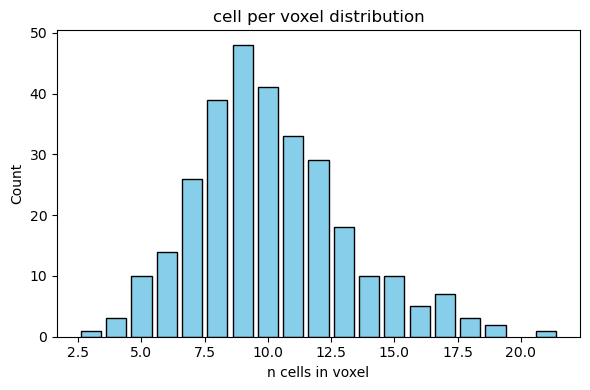

In [6]:
# Extract keys and values
labels = list(hist_cell_per_voxel.keys())
counts = list(hist_cell_per_voxel.values())

# Plot histogram (bar plot for discrete categories)
plt.figure(figsize=(6, 4))
plt.bar(labels, counts, color='skyblue', edgecolor='black')

plt.xlabel('n cells in voxel')
plt.ylabel('Count')
plt.title('cell per voxel distribution')
plt.tight_layout()
plt.show()

In [ ]:
#--------- Check neighbors --------------

In [12]:
post_process = EM_postprocess(
    candidates, adata_sc, adata_st,
    n_cells_spot=10,
    spatial_coords=adata_st.obsm["spatial"],
    max_iter=100, alpha=1.0, beta=1.0
)

In [13]:
post_process.run_EM()
pathlib.Path("results").mkdir(parents=True, exist_ok=True)

with open("results/em_log.pkl", "wb") as f:
    pickle.dump(post_process.logs, f)

with open("results/em_object.pkl", "wb") as f:
    pickle.dump(post_process, f)

KeyError: 233

In [34]:
post_process.assess_EM()

Find results in self.result_vox_sim and self.result_neigh_sim


In [36]:
post_process.result_neigh_sim

[0.9011978,
 0.8976959,
 0.22515209,
 0.9985418,
 0.8398818,
 0.7276004,
 0.9979438,
 0.8621737,
 0.8663267,
 0.9478905,
 0.9209804,
 0.8045979,
 nan,
 0.1322468,
 0.7706575,
 0.8950739,
 0.9630397,
 0.77844435,
 0.9907385,
 0.9704492,
 nan,
 0.97446454,
 0.32330102,
 0.9673374,
 0.9517544,
 0.95461744,
 0.9540453,
 0.34575394,
 nan,
 0.7354849,
 0.9760394,
 0.97525907,
 nan,
 0.60502625,
 0.8528804,
 0.86435187,
 0.9972072,
 0.945656,
 0.9543169,
 0.9817598,
 0.9605312,
 0.42795983,
 0.42723373,
 0.995374,
 0.41307673,
 0.9655505,
 0.9959452,
 0.8233609,
 0.93485975,
 0.97593486,
 nan,
 0.92647976,
 0.6119283,
 0.94113344,
 0.9571493,
 0.118922725,
 0.8268535,
 0.7491604,
 0.6349319,
 0.94485205,
 0.47181284,
 0.6921769,
 0.944379,
 0.91093576,
 0.78830755,
 0.37938583,
 0.837394,
 0.9440968,
 0.99656177,
 0.97260916,
 0.9783654,
 0.85041183,
 0.81728274,
 0.81427735,
 0.9941537,
 nan,
 nan,
 nan,
 nan,
 0.9852526,
 0.9914841,
 0.8359208,
 0.74166125,
 0.9666312,
 0.8604967,
 0.976244